# Synthetic data test: Model with multiple sources and moving window scheme

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler
import skimage
import xarray as xr

In [2]:
def detect_anomalies(
    data, size_range, size_increment=2, nsizes=10, threshold=0.5, overlap=0.5, exclude_border=0
):
    """
    Run the blob detection and produce bounding boxes in data coordinates
    """
    min_sigma, max_sigma = [0.5 * i for i in size_range]
    spacing = np.mean([np.abs(data.easting[1] - data.easting[0]), np.abs(data.northing[1] - data.northing[0])])
    iy, ix, sigma_pix = skimage.feature.blob_log(
        data,
        min_sigma=min_sigma / spacing,
        max_sigma=max_sigma / spacing,
        threshold=threshold,
        num_sigma=nsizes,
        overlap=overlap,
        exclude_border= int(exclude_border / spacing),
    ).T
    blob_coords = (data.easting.values[ix.astype("int")], data.northing.values[iy.astype("int")])
    blob_sizes = sigma_pix * np.sqrt(2) * spacing * size_increment
    windows = [
        [x - size, x + size, y - size, y + size]
        for size, x, y in zip(blob_sizes, *blob_coords)
    ]
    return windows

## Make a model with multiple sources

Number of data: 22701


/home/gelson/anaconda3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


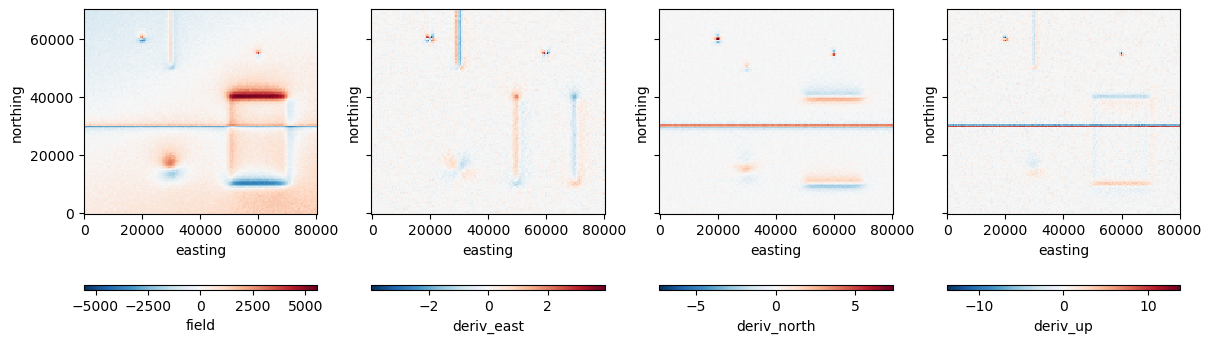

In [3]:
region = [0, 80e3, 0, 70e3]
coordinates = vd.grid_coordinates(region, spacing=500, extra_coords=1000)
inclination, declination = -30, -10
base_level = 500
noise_level = 100
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)

# Dipoles
dipole_coordinates = (30e3, 15e3, -3e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))
dipole2_coordinates = (20e3, 60e3, 0e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole2_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(5e10, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Pipe
size = 50
pipe_coordinates = (60e3, 55e3, 500)
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        pipe_coordinates[0] - size,
        pipe_coordinates[0] + size,
        pipe_coordinates[1] - size,
        pipe_coordinates[1] + size,
        pipe_coordinates[2] - 15e3,
        pipe_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(2000, -90, 0),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Dike
dike_coordinates = (30e3, 30e3, 900)
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        dike_coordinates[0] - 100e3,
        dike_coordinates[0] + 100e3,
        dike_coordinates[1] - 100,
        dike_coordinates[1] + 100,
        dike_coordinates[2] - 7e3,
        dike_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(20, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Line
line_coordinates = [30e3, 50e3, 0]
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        line_coordinates[0] - 50,
        line_coordinates[0] + 50,
        line_coordinates[1],
        line_coordinates[1] + 100e3,
        line_coordinates[2] - 50,
        line_coordinates[2] + 50,
    ],
    magnetization=hm.magnetic_angles_to_vec(3000, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Sill
sill_coordinates = [60e3, 25e3, -0.5e3]
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        sill_coordinates[0] - 10e3,
        sill_coordinates[0] + 10e3,
        sill_coordinates[1] - 15e3,
        sill_coordinates[1] + 15e3,
        sill_coordinates[2] - 100,
        sill_coordinates[2] + 100,
    ],
    magnetization=hm.magnetic_angles_to_vec(200, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Regional
magnetic_anomaly += 0.01 * coordinates[0] - 0.02 * coordinates[1]

# Add noise and the base level
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(
    coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"]
)

data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)


fig, axes = plt.subplots(1, 4, figsize=(12, 6), layout="constrained", sharey=True)
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
plt.show()

# Calculating Total Grandient Anomaly

In [4]:
data = data.assign(tga = np.sqrt(data.deriv_east**2+data.deriv_north**2+data.deriv_up**2))
data

<xarray.Dataset> Size: 1MB
Dimensions:      (northing: 141, easting: 161)
Coordinates:
    height       (northing, easting) float64 182kB 1e+03 1e+03 ... 1e+03 1e+03
  * easting      (easting) float64 1kB 0.0 500.0 1e+03 ... 7.95e+04 8e+04
  * northing     (northing) float64 1kB 0.0 500.0 1e+03 ... 6.95e+04 7e+04
Data variables:
    field        (northing, easting) float64 182kB 519.9 390.1 ... -272.4 -313.4
    deriv_east   (northing, easting) float64 182kB -0.2596 0.05395 ... -0.08181
    deriv_north  (northing, easting) float64 182kB -0.2265 0.6132 ... -0.1809
    deriv_up     (northing, easting) float64 182kB -0.3254 0.5841 ... 0.3644
    tga          (northing, easting) float64 182kB 0.4739 0.8486 ... 0.415

In [5]:
stretched = skimage.exposure.rescale_intensity(
    data.tga, 
    in_range=tuple(np.percentile(data.tga, (0.5, 99.5))),
)
data = data.assign(tga_stretched=xr.DataArray(stretched, coords=data.coords))
data

<xarray.Dataset> Size: 1MB
Dimensions:        (northing: 141, easting: 161)
Coordinates:
    height         (northing, easting) float64 182kB 1e+03 1e+03 ... 1e+03 1e+03
  * easting        (easting) float64 1kB 0.0 500.0 1e+03 ... 7.95e+04 8e+04
  * northing       (northing) float64 1kB 0.0 500.0 1e+03 ... 6.95e+04 7e+04
Data variables:
    field          (northing, easting) float64 182kB 519.9 390.1 ... -313.4
    deriv_east     (northing, easting) float64 182kB -0.2596 ... -0.08181
    deriv_north    (northing, easting) float64 182kB -0.2265 0.6132 ... -0.1809
    deriv_up       (northing, easting) float64 182kB -0.3254 0.5841 ... 0.3644
    tga            (northing, easting) float64 182kB 0.4739 0.8486 ... 0.415
    tga_stretched  (northing, easting) float64 182kB 0.04517 0.08652 ... 0.03868

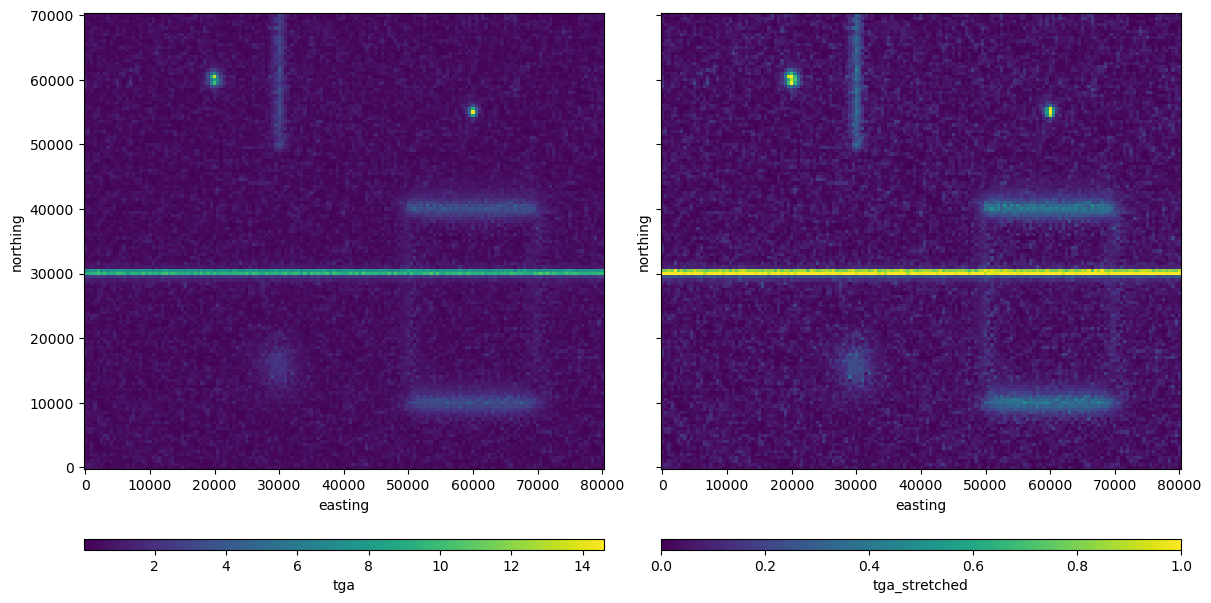

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), layout="constrained", sharey=True)
for field, ax in zip(["tga", "tga_stretched"], axes.ravel()):
    data[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
plt.show()

# Windows selection using blob detecion

In [7]:
windows = detect_anomalies(
    data.tga_stretched, 
    size_range=[2e3, 10e3],
    size_increment=1.5,
    threshold=0.05,
    overlap=0.3,
    nsizes=20,
    exclude_border=500
)

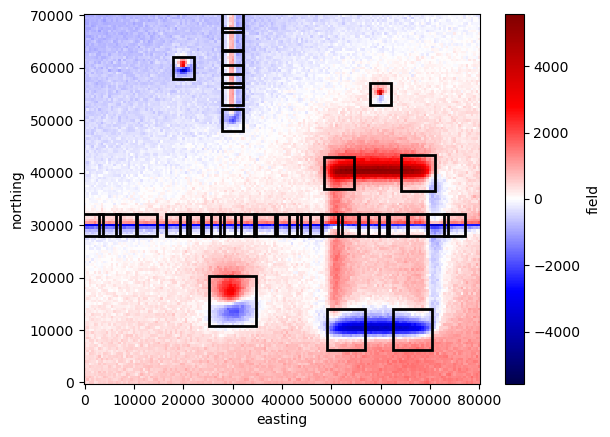

In [8]:
import matplotlib.patches
ax = plt.subplot(111)
data.field.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect) 

## Run Euler Deconvolution and Inversion

In [9]:
data

<xarray.Dataset> Size: 1MB
Dimensions:        (northing: 141, easting: 161)
Coordinates:
    height         (northing, easting) float64 182kB 1e+03 1e+03 ... 1e+03 1e+03
  * easting        (easting) float64 1kB 0.0 500.0 1e+03 ... 7.95e+04 8e+04
  * northing       (northing) float64 1kB 0.0 500.0 1e+03 ... 6.95e+04 7e+04
Data variables:
    field          (northing, easting) float64 182kB 519.9 390.1 ... -313.4
    deriv_east     (northing, easting) float64 182kB -0.2596 ... -0.08181
    deriv_north    (northing, easting) float64 182kB -0.2265 0.6132 ... -0.1809
    deriv_up       (northing, easting) float64 182kB -0.3254 0.5841 ... 0.3644
    tga            (northing, easting) float64 182kB 0.4739 0.8486 ... 0.415
    tga_stretched  (northing, easting) float64 182kB 0.04517 0.08652 ... 0.03868

In [10]:
# Inicialize o dicionário de deconvoluções
deconvolutions = {1: [], 2: [], 3: []}

# Exemplo de dados gerados para cada chave
for window in windows:
    # Slicing os dados da janela
    data_slice = data.sel(easting=slice(*window[:2]), northing=slice(*window[2:]))
    for si in deconvolutions.keys():
        # Cria uma nova instância de EulerDeconvolution e ajusta os dados
        deconvolution_result = euler.EulerDeconvolution(structural_index=si).fit_grid(data_slice)
        # Armazena o resultado na lista correspondente
        deconvolutions[si].append(deconvolution_result)


In [11]:
%%time
ei = {1: [], 2: [], 3: []}
for window in windows:
    #slice the window data
    data_slice = data.sel(easting=slice(*window[:2]), northing=slice(*window[2:]))
    # choose the best si
    tolerance = np.inf
    variance = 0
    for si in deconvolutions.keys():
        ei_result =  euler.EulerInversion(si).fit_grid(data_slice)
        variance = np.sum(np.diag(ei_result.covariance_)[:3])

        if variance <= tolerance:
            chosen_si = si         # updates the chosen si
            tolerance = variance   # updates the variance for a lesser one

    ei[chosen_si].append(euler.EulerInversion(chosen_si).fit_grid(data_slice))
        

CPU times: user 1.42 s, sys: 7.67 ms, total: 1.43 s
Wall time: 1.42 s


In [12]:
%%time
ei = {1: [], 2: [], 3: []}
for window in windows:
    #slice the window data
    data_slice = data.sel(easting=slice(*window[:2]), northing=slice(*window[2:]))
    # choose the best si
    tolerance = -np.inf
    for si in deconvolutions.keys():
        ei_result =  euler.EulerInversion(si).fit_grid(data_slice)

        weights = np.array([1,0.1,0.1,0.05])
        variables = ['field', 'deriv_east', 'deriv_north', 'deriv_up',]
        pred_variables = (ei_result.predicted_field_.ravel(), ei_result.predicted_deriv_east_.ravel(),
                          ei_result.predicted_deriv_north_.ravel(), ei_result.predicted_deriv_up_.ravel())
        r2=0
        for weight, variable, d_predicted in zip(weights, variables, pred_variables):
            d = data_slice[variable].values.ravel()

            residuals = d - d_predicted
            residuals_sum_sq = np.sum(residuals**2)
            
            r2 += (1 - residuals_sum_sq / np.linalg.norm(d - d.mean()) ** 2) * weight

        r2 /= weights.sum()

        if r2 >= tolerance:
            chosen_si = si   # updates the chosen si
            tolerance = r2   # updates the r2 for a bigger one
    
    ei[chosen_si].append(euler.EulerInversion(chosen_si).fit_grid(data_slice))

CPU times: user 1.44 s, sys: 11.2 ms, total: 1.45 s
Wall time: 1.44 s


In [13]:
data_slice

<xarray.Dataset> Size: 4kB
Dimensions:        (northing: 7, easting: 9)
Coordinates:
    height         (northing, easting) float64 504B 1e+03 1e+03 ... 1e+03 1e+03
  * easting        (easting) float64 72B 2.8e+04 2.85e+04 ... 3.15e+04 3.2e+04
  * northing       (northing) float64 56B 6.7e+04 6.75e+04 ... 6.95e+04 7e+04
Data variables:
    field          (northing, easting) float64 504B -472.9 -317.9 ... -781.7
    deriv_east     (northing, easting) float64 504B 0.2543 0.4543 ... 0.244
    deriv_north    (northing, easting) float64 504B 0.1497 0.1034 ... 0.1171
    deriv_up       (northing, easting) float64 504B 0.109 0.04063 ... -0.17
    tga            (northing, easting) float64 504B 0.3146 0.4677 ... 0.3197
    tga_stretched  (northing, easting) float64 504B 0.0276 0.04449 ... 0.02816

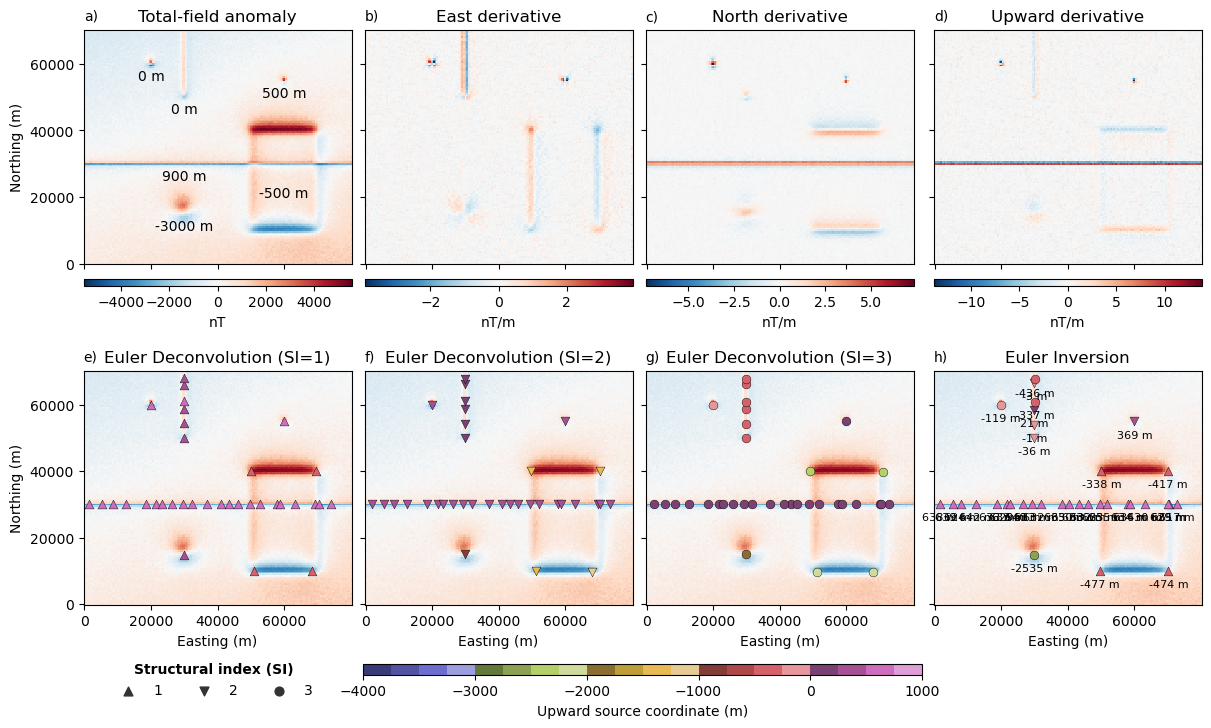

In [14]:
fig, axes = plt.subplots(
    2, 4, figsize=(12, 7.3), layout="constrained", sharey=True, sharex=True
)

subplot_labels = [f"{i})" for i in "abcdefgh"]
units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
data_names = {
    "field": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
markers = ["^", "v", "o"]
vmin, vmax = -4000, 1000
size = 40
true_sources = [
    dipole_coordinates,
    dipole2_coordinates,
    dike_coordinates,
    sill_coordinates,
    pipe_coordinates,
    line_coordinates,
]

for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes[0, :]):
    ax.set_aspect("equal")
    tmp = data[field].plot.pcolormesh(ax=ax, add_colorbar=False, add_labels=False)
    fig.colorbar(
        tmp, ax=ax, orientation="horizontal", aspect=40, pad=0.02, label=units[field]
    )
    ax.set_title(data_names[field])
ax = axes[0, 0]
for source in true_sources:
    ax.text(
        source[0], source[1] - 5e3, f"{source[2]:.0f} m", horizontalalignment="center"
    )
for ax in axes[1, :]:
    ax.set_aspect("equal")
    data.field.plot.pcolormesh(ax=ax, add_colorbar=False, add_labels=False)

# Euler deconvolution
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :-1]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    for k, window in enumerate(windows):
        ax.scatter(
            *deconvolutions[si][k].location_[:2],
            c=deconvolutions[si][k].location_[2],
            s=size,
            marker=marker,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=0.3,
            cmap="tab20b",
        )
# Euler inversion
labels = {}
ax = axes[1, -1]
ax.set_title("Euler Inversion")

for si, marker in zip(ei.keys(), markers):
    for k, solution in enumerate(ei[si]):

        tmp = ax.scatter(
            *solution.location_[:2],
            c=solution.location_[2],
            s=size,
            marker=marker,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=0.3,
            cmap="tab20b",
        )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

for si in ei.keys():
    for k, solution in enumerate(ei[si]):
        ax.text(
            solution.location_[0], solution.location_[1] - 5e3, 
            f"{solution.location_[2]:.0f} m", horizontalalignment="center",
            fontsize=8
        )
    
fig.colorbar(
    tmp,
    ax=axes[1, :],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)
fig.legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    ncols=3,
    title="Structural index (SI)",
    loc="lower left",
    bbox_to_anchor=[0.08, 0.015],
    title_fontproperties=dict(weight="bold"),
)

for ax, label in zip(axes.ravel(), subplot_labels):
    ax.text(0, 1.04, label, transform=ax.transAxes)
for ax in axes[1, :]:
    ax.set_xticks(np.arange(0, 61e3, 20e3))
for ax in axes[:, 0]:
    ax.set_yticks(np.arange(0, 61e3, 20e3))
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[1, :]:
    ax.set_xlabel("Easting (m)")

# for dpi, res in zip([70, 300], ["", "-highres"]):
    # fig.savefig(
    #     f"../paper/figures/synthetic-windows{res}.png", dpi=dpi, bbox_inches="tight"
    # )

plt.show()